In [1]:
from fastai.vision.all import *


In [2]:
dk_dir = Path("dk_bugs")
fin_dir = Path("finland_bugs")
ept_dir = Path("ept_bugs_preproc")
model_dir = Path(".")

In [3]:
print(len(get_image_files(dk_dir)))
print(len(get_image_files(fin_dir)))
print(len(get_image_files(ept_dir)))

845
15074
4784


In [4]:
fin_dl = ImageDataLoaders.from_folder(path=fin_dir, valid_pct=0.2, bs=64, batch_tfms=aug_transforms(mult=2, size=224, flip_vert=True))
ept_dl = ImageDataLoaders.from_folder(path=ept_dir, valid_pct=0.2, bs=64, batch_tfms=aug_transforms(mult=2, flip_vert=True))

In [5]:
#dk_dl = ImageDataLoaders.from_folder(path=dk_dir, valid_pct=0.2, bs=32, item_tfms=Resize(224*3), batch_tfms=aug_transforms(mult=2, size=224, min_scale=0.85, flip_vert=True))
targets = [parent_label(i) for i in get_image_files(dk_dir)]
dk_dl = DataBlock(blocks = (ImageBlock,CategoryBlock),
                  get_items = get_image_files,
                  splitter = TrainTestSplitter(stratify=targets),
                  item_tfms=Resize(224*3), 
                  batch_tfms=aug_transforms(mult=2, size=224, min_scale=0.85, flip_vert=True),
                  get_y = parent_label).dataloaders(dk_dir, batch_size = 64)

In [6]:
dk_n = len(dk_dl.vocab)
fin_n = len(fin_dl.vocab)
ept_n = len(ept_dl.vocab)

print(dk_n)
print(fin_n)
print(ept_n)


21
64
28


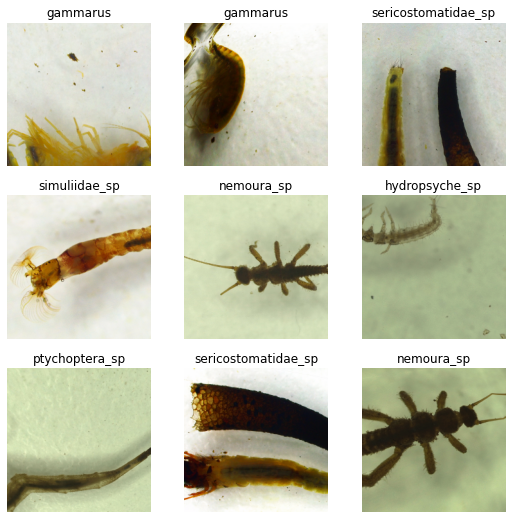

In [7]:
dk_dl.show_batch()

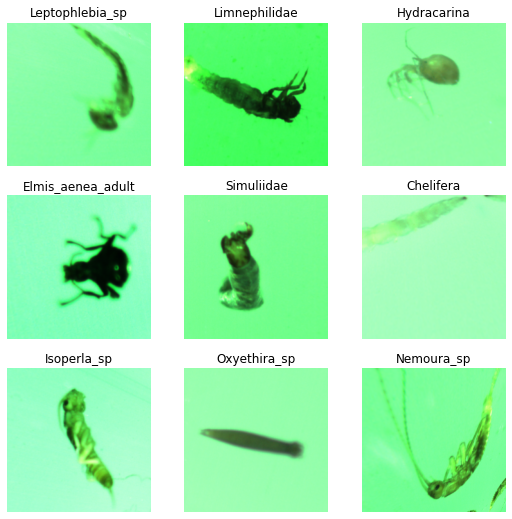

In [8]:
fin_dl.show_batch()

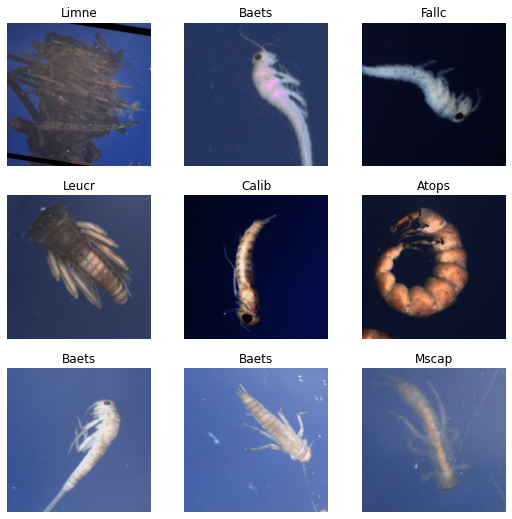

In [9]:
ept_dl.show_batch()

In [12]:
fin_learn = cnn_learner(fin_dl, resnet34, metrics=error_rate, path = model_dir)

In [13]:
fin_learn.fine_tune(9, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,4.016485,2.259478,0.580624,00:35
1,2.565856,1.433429,0.411413,00:35
2,2.035415,1.174843,0.348706,00:35


epoch,train_loss,valid_loss,error_rate,time
0,1.485442,0.857337,0.271732,00:44
1,1.179864,0.731834,0.233245,00:45
2,0.997696,0.597827,0.188454,00:44
3,0.763698,0.490579,0.163902,00:44
4,0.640525,0.411110,0.136364,00:45
5,0.528136,0.327518,0.111480,00:45
6,0.425199,0.286753,0.100531,00:45
7,0.376151,0.270791,0.093232,00:44
8,0.330295,0.263065,0.092236,00:45


In [14]:
fin_learn.model[-1][-1]=nn.Linear(in_features=512, out_features=ept_n, bias=False)
fin_learn.save("resnet34-fin")

Path('models/resnet34-fin.pth')

In [15]:
ept_learn = cnn_learner(ept_dl, resnet34, metrics=error_rate, path = model_dir)
ept_learn.load("resnet34-fin")

In [16]:
ept_learn.fine_tune(4, freeze_epochs=2)

epoch,train_loss,valid_loss,error_rate,time
0,2.370871,1.217452,0.317992,00:11
1,1.163194,0.494271,0.153766,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.456212,0.311791,0.095188,00:14
1,0.306936,0.176354,0.056485,00:14
2,0.205355,0.146175,0.046025,00:14
3,0.148347,0.116808,0.035565,00:14


In [17]:
ept_learn.model[-1][-1]=nn.Linear(in_features=512, out_features=dk_n, bias=False)
ept_learn.save("resnet34-fin-ept")

Path('models/resnet34-fin-ept.pth')

In [7]:
dk_learn = cnn_learner(dk_dl, resnet34, metrics=error_rate, path = model_dir) #, cbs=MixUp(), loss_func=LabelSmoothingCrossEntropy()
dk_learn.load("resnet34-fin-ept")

In [8]:
dk_learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,3.127232,2.634300,0.727811,00:09
1,2.558431,1.040012,0.201183,00:08
2,1.898426,0.451995,0.130178,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.542455,0.325778,0.088757,00:09
1,0.473910,0.225871,0.071006,00:09
2,0.402500,0.163385,0.053254,00:08
3,0.323643,0.110130,0.023669,00:09
4,0.276483,0.101874,0.029586,00:09
5,0.237771,0.096588,0.023669,00:09


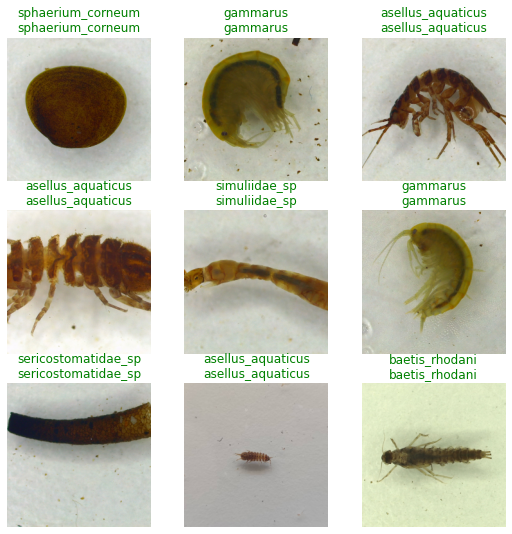

In [9]:
dk_learn.show_results()


In [10]:
dk_learn.export(Path("models")/"resnet34-fin-ept-dk.export")

In [11]:
preds, y, losses = dk_learn.get_preds(with_loss=True)
interp = ClassificationInterpretation.from_learner(dk_learn)

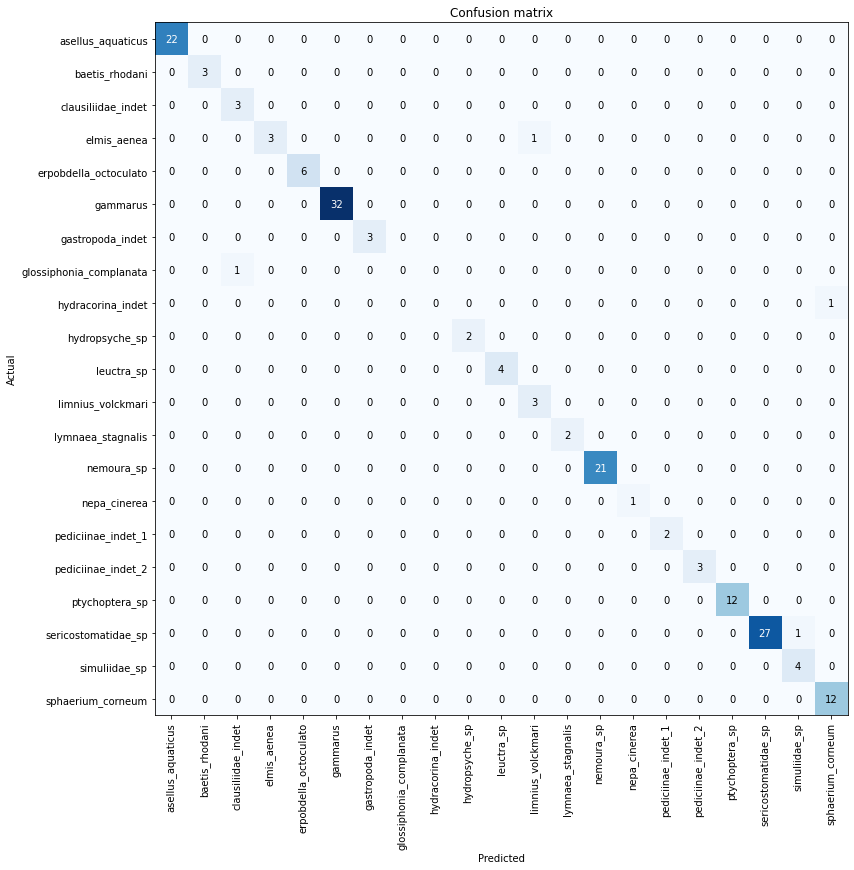

In [12]:
interp.plot_confusion_matrix(figsize=(12,12))
